In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.float_format', lambda x: '%.2f' % x)
import warnings
from scipy import stats
warnings.simplefilter(action='ignore', category=FutureWarning)
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# **1.2 EDA**

We use the ELTclass we previously created to load, transform and combine data

In [2]:
class ELTclass:
    def __init__(self, item_cat_path, items_path, shops_path, sales_train_path):
        self.item_cat_path = item_cat_path
        self.items_path = items_path
        self.shops_path = shops_path
        self.sales_train_path = sales_train_path

    def read_data(self):
        df_item_cat = pd.read_csv(self.item_cat_path, dtype={'item_category_name': 'str', 'item_category_id': 'int32'})
        df_items = pd.read_csv(self.items_path, dtype={'item_name': 'str', 'item_id': 'int32', 'item_category_id': 'int32'})
        df_shops = pd.read_csv(self.shops_path, dtype={'shop_name': 'str', 'shop_id': 'int32'})
        sales_train = pd.read_csv(self.sales_train_path, dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})
        return df_item_cat, df_items, df_shops, sales_train

    def get_merged_data(self):
        df_item_cat, df_items, df_shops, sales_train = self.read_data()
        data = sales_train.copy()
        # Define the common column for the first merge
        common_column = None
        # Iterate over each dataset
        for df in [df_items, df_item_cat, df_shops]:
            # Find the common column for merging
            if common_column is None:
                common_column = set(data.columns) & set(df.columns)
            else:
                common_column = list(set(data.columns) & set(df.columns))

            # Perform left merge
            data = pd.merge(data, df, on=list(common_column), how='left')
            data['date'] = pd.to_datetime(data['date'], format='%d.%m.%Y')

        #Replace duplicate shop_ids
        data.loc[data['shop_id'] == 0, 'shop_id'] = 57
        data.loc[data['shop_id'] == 1, 'shop_id'] = 58
        data.loc[data['shop_id'] == 11, 'shop_id'] = 10
        data.loc[data['shop_id'] == 40, 'shop_id'] = 39

        # Filter data from system emissions
        # Calculate the mean quantity and price for each item
        mean_quantity_by_item = data.groupby('item_name')['item_cnt_day'].mean()
        mean_price_by_item = data.groupby('item_name')['item_price'].mean()

        # Filter rows where the quantity or price exceeds 100 times the mean value for the respective item
        outliers_quantity = data[data['item_cnt_day'] > 100 * data['item_name'].map(mean_quantity_by_item)]
        outliers_price = data[data['item_price'] > 10 * data['item_name'].map(mean_price_by_item)]
        # Find the item with the maximum price
        max_price_item = data.loc[data['item_price'].idxmax(), 'item_name']

        # Remove outliers and the item with the maximum price from the dataset
        data = data.drop(outliers_quantity.index)
        data = data.drop(outliers_price.index)
        data = data[data['item_name'] != max_price_item]
        data = data.query('item_price > 0 & item_cnt_day > 0')

        return data
# Example usage of the class
item_cat_path = '/content/drive/MyDrive/Predict Future Sales/item_categories.csv'
items_path = '/content/drive/MyDrive/Predict Future Sales/items.csv'
shops_path = '/content/drive/MyDrive/Predict Future Sales/shops.csv'
sales_train_path = '/content/drive/MyDrive/Predict Future Sales/sales_train.csv'

elt = ELTclass(item_cat_path=item_cat_path, items_path=items_path, shops_path=shops_path, sales_train_path=sales_train_path)
# Get merged data
merged_data = elt.get_merged_data()
merged_data.shape

(2928449, 10)

In [ ]:
merged_data.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2928449.00,2928449.00,2928449.00,2928449.00,2928449.00,2928449.00
mean,14.57,33.30,10200.27,889.30,1.25,40.02
std,9.42,16.14,6324.42,1717.66,2.16,17.10
min,0.00,2.00,0.00,0.07,1.00,0.00
25%,7.00,22.00,4477.00,249.00,1.00,28.00
50%,14.00,31.00,9355.00,399.00,1.00,40.00
75%,23.00,48.00,15691.00,999.00,1.00,55.00
max,33.00,59.00,22169.00,50999.00,669.00,83.00


# **EDA**

# It is necessary to answer the following questions based on the results of the dataset research:
1. How are overall sales performing throughout the year?
2. What is the distribution by sales categories? Which categories have the most sales? By quantity and amount?
3. What is the distribution of sales by city? Which cities sell the most on average?
4. Which stores sell the most?

# **How are overall sales performing throughout the year?**


# Let's group the data by month for later analysis

In [3]:
data = merged_data.copy()
data = data.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id','item_category_name',
'shop_name'], as_index=False).agg({'item_price':['min','mean'], 'item_cnt_day':['sum']})
data.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id','item_category_name',
'shop_name','item_price_min','item_price_mean','item_cnt']

<Axes: xlabel='date_block_num', ylabel='item_cnt'>

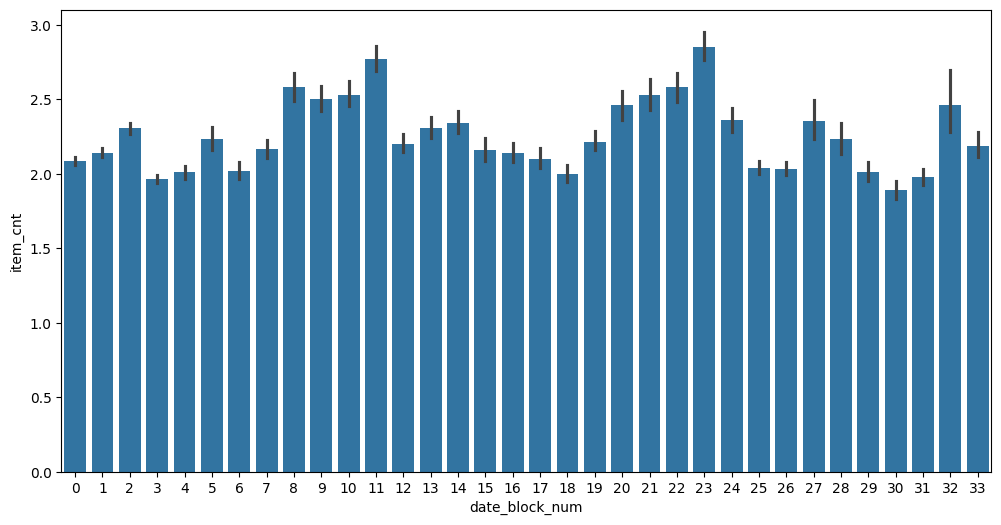

In [4]:
figure, ax = plt.subplots()
figure.set_size_inches(12, 6)
sns.barplot(x='date_block_num', y='item_cnt', data=data)

# Let's transform shop_name and category_name and look at the distribution of sales by category and city

In [5]:
data['item_category_name'] = data['item_category_name'].apply(lambda name: re.sub(r'[^\w\s]', '', str(name).split()[0]).strip())
data['shop_name'] = data['shop_name'].apply(lambda name: re.sub(r'[^\w\s]', '', str(name).split()[0]).strip())

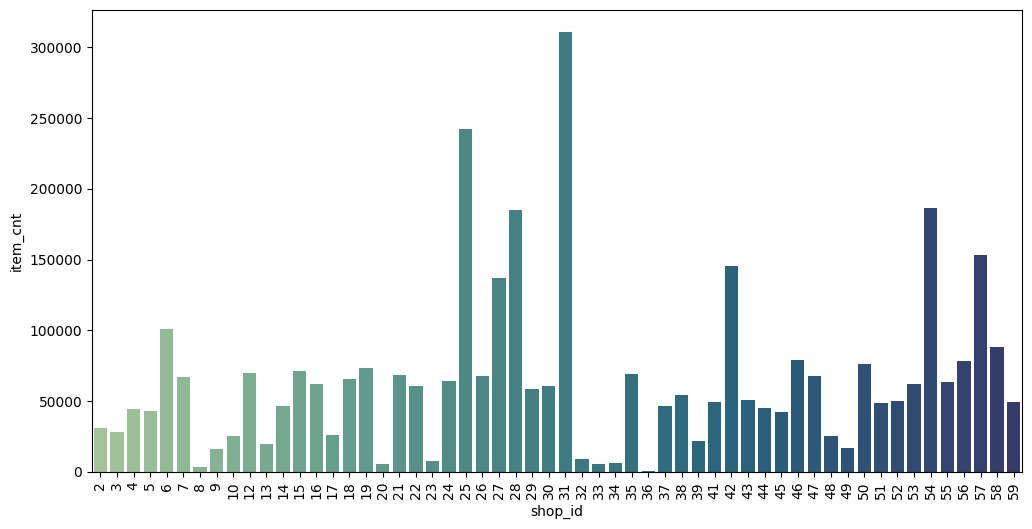

In [ ]:
gp_shop_sum = data.groupby(['shop_id'], as_index=False)['item_cnt'].sum()
figure, ax = plt.subplots()
figure.set_size_inches(12, 6)
sns.barplot(x='shop_id', y='item_cnt', data=gp_shop_sum, palette="crest")
plt.xticks(rotation=90)
plt.show()

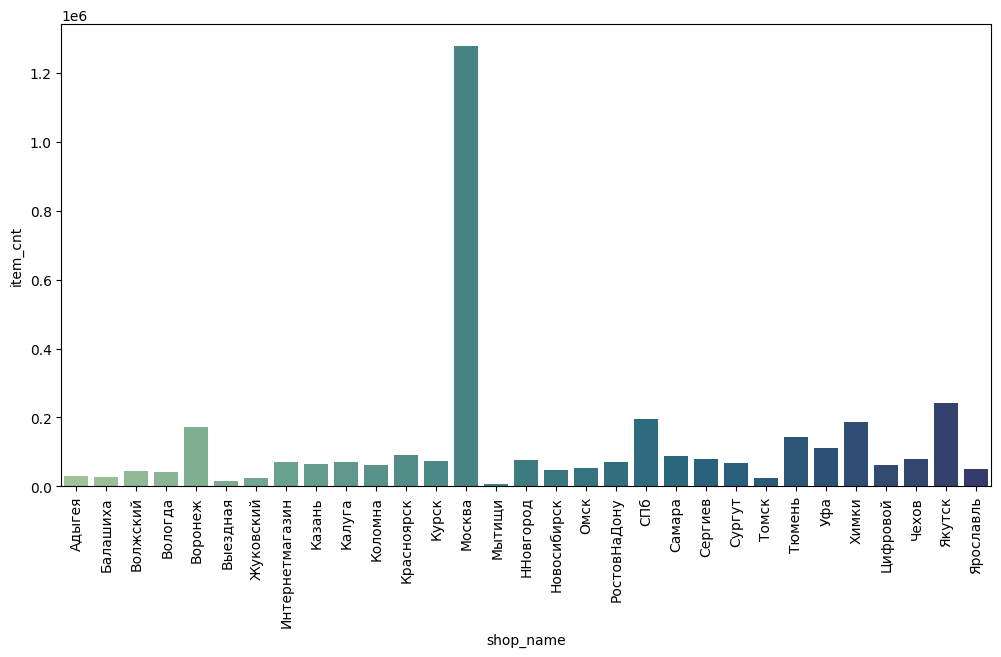

In [ ]:
gp_shop_sum = data.groupby(['shop_name'], as_index=False)['item_cnt'].sum()
figure, ax = plt.subplots()
figure.set_size_inches(12, 6)
sns.barplot(x='shop_name', y='item_cnt', data=gp_shop_sum, palette="crest")
plt.xticks(rotation=90)
plt.show()

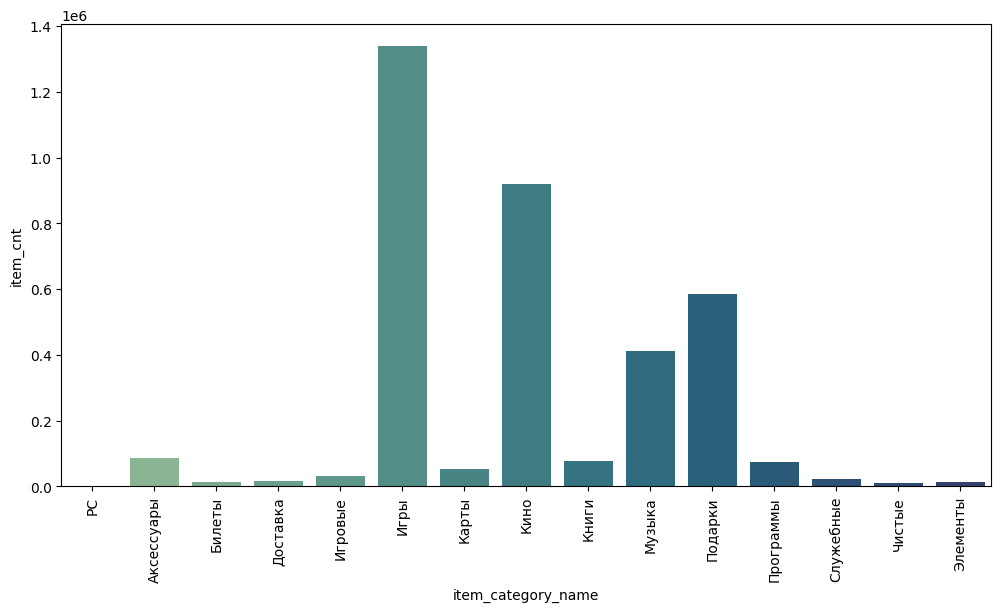

In [ ]:
gp_cat_sum = data.groupby(['item_category_name'], as_index=False)['item_cnt'].sum()
figure, ax = plt.subplots()
figure.set_size_inches(12, 6)
sns.barplot(x='item_category_name', y='item_cnt', data=gp_cat_sum, palette="crest")
plt.xticks(rotation=90)
plt.show()

# **Target Variable Distribution**


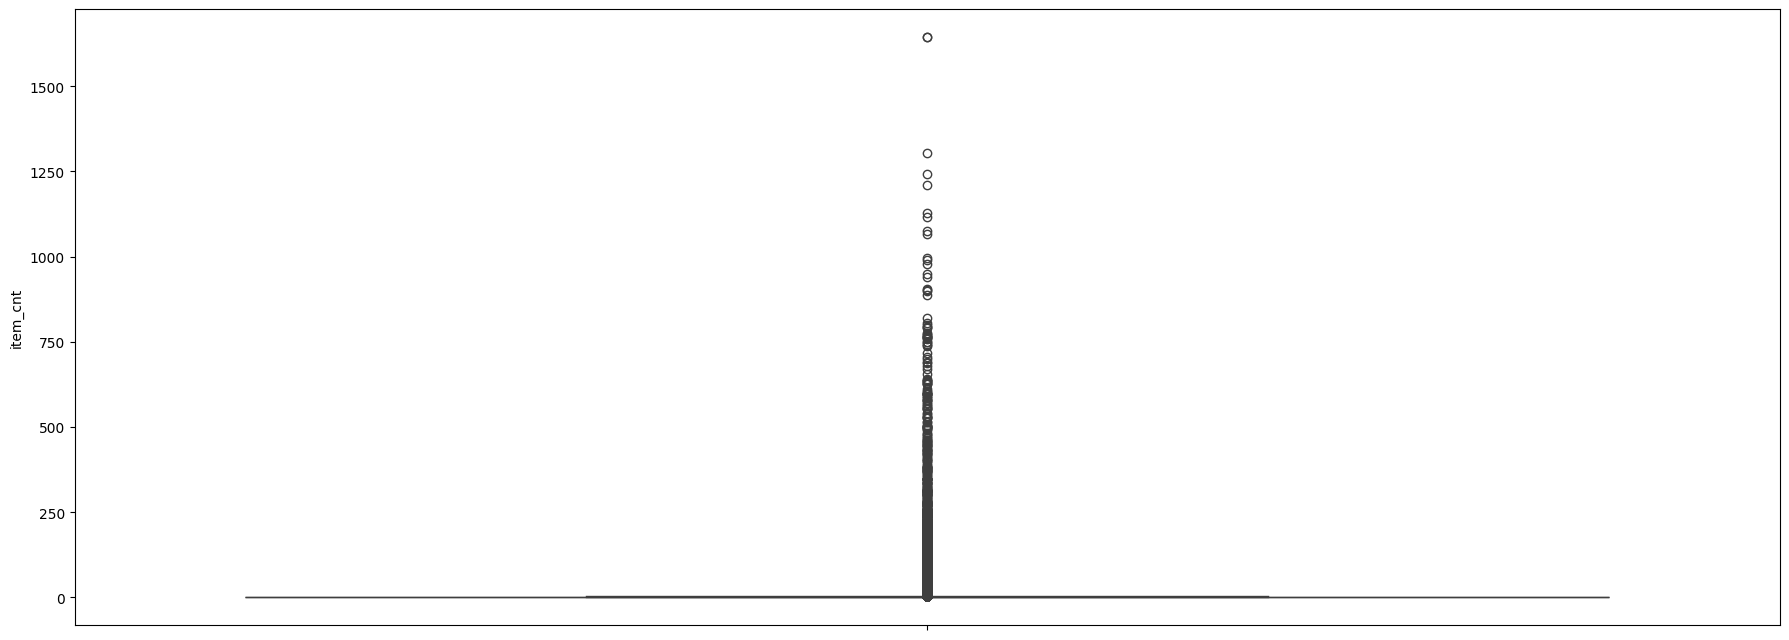

In [ ]:
plt.subplots(figsize=(22, 8))
sns.boxplot(data['item_cnt'])
plt.show()

In [ ]:
data.head()

,date_block_num,shop_id,item_category_id,item_id,item_category_name,shop_name,item_price_min,item_price_mean,item_cnt
0,0,2,2,5572,Аксессуары,Адыгея,1490.00,1532.86,9
1,0,2,2,5573,Аксессуары,Адыгея,849.00,924.00,2
2,0,2,2,5575,Аксессуары,Адыгея,550.02,955.01,4
3,0,2,2,5576,Аксессуары,Адыгея,2490.00,2490.00,3
4,0,2,2,5632,Аксессуары,Адыгея,2390.00,2390.00,1


In [8]:
def top_10_items(df):
    top_items = df.nlargest(20, 'item_cnt')
    for index, row in top_items.iterrows():
        item_name = row['item_category_name']
        quantity = row['item_cnt']
        cat_id = row['item_category_id']
        mean_quantity = df[df['item_category_name'] == item_name]['item_cnt'].mean()
        print(f"Category name: {item_name}, category id: {cat_id},item_cnt: {quantity}, Mean quantity: {mean_quantity}")

top_10_items(data)

Category name: Служебные, category id: 80,item_cnt: 1644, Mean quantity: 15.867052023121387
Category name: Билеты, category id: 8,item_cnt: 1644, Mean quantity: 43.814696485623
Category name: Подарки, category id: 71,item_cnt: 1305, Mean quantity: 2.887170460613492
Category name: Игры, category id: 31,item_cnt: 1242, Mean quantity: 3.0343017849447733
Category name: Подарки, category id: 71,item_cnt: 1209, Mean quantity: 2.887170460613492
Category name: Игры, category id: 31,item_cnt: 1127, Mean quantity: 3.0343017849447733
Category name: Билеты, category id: 8,item_cnt: 1117, Mean quantity: 43.814696485623
Category name: Игры, category id: 31,item_cnt: 1074, Mean quantity: 3.0343017849447733
Category name: Подарки, category id: 71,item_cnt: 1066, Mean quantity: 2.887170460613492
Category name: Подарки, category id: 71,item_cnt: 997, Mean quantity: 2.887170460613492
Category name: Подарки, category id: 71,item_cnt: 989, Mean quantity: 2.887170460613492
Category name: Подарки, category i

# There are outliers in various categories. It is necessary to clean the dataset from obvious outliers within each category

In [ ]:
# def filter_outliers(df, column_names, lower_quantile=0.01, upper_quantile=0.99, groupby_column='item_category_name'):
#     for column_name in column_names:
#         outlier_mask = df.groupby(groupby_column)[column_name].transform(
#             lambda x: (x < x.quantile(lower_quantile)) | (x > x.quantile(upper_quantile))
#         )
#         df = df[~outlier_mask]
#     return df

# filtered_train = filter_outliers(data, column_names = ['item_cnt'])
# print(f'The number of observations after clearing emissions decreased by {len(data) - len(filtered_train)}')

The number of observations after clearing emissions decreased by 12421


# In order not to lose the necessary observations, I decided not to delete observations, but to cut the outlier values ​​to the values ​​of the upper and lower quantiles

In [9]:
data['item_cnt'] = data.groupby('item_category_name')['item_cnt'].transform(lambda x: x.clip(x.quantile(0.01), x.quantile(0.99)))

In [10]:
top_10_items(data)

Category name: Билеты, category id: 8,item_cnt: 714.92, Mean quantity: 38.95424920127795
Category name: Билеты, category id: 8,item_cnt: 714.92, Mean quantity: 38.95424920127795
Category name: Билеты, category id: 8,item_cnt: 714.92, Mean quantity: 38.95424920127795
Category name: Билеты, category id: 8,item_cnt: 714.92, Mean quantity: 38.95424920127795
Category name: Билеты, category id: 8,item_cnt: 707.0, Mean quantity: 38.95424920127795
Category name: Доставка, category id: 9,item_cnt: 603.8200000000014, Mean quantity: 78.72180904522615
Category name: Доставка, category id: 9,item_cnt: 603.8200000000014, Mean quantity: 78.72180904522615
Category name: Доставка, category id: 9,item_cnt: 601.0, Mean quantity: 78.72180904522615
Category name: Билеты, category id: 8,item_cnt: 597.0, Mean quantity: 38.95424920127795
Category name: Доставка, category id: 9,item_cnt: 578.0, Mean quantity: 78.72180904522615
Category name: Билеты, category id: 8,item_cnt: 539.0, Mean quantity: 38.95424920127

# I think these positions can no longer be considered outliers, since purely theoretically, ticket sales and delivery may significantly exceed the average in some months

Text(0, 0.5, 'Частота')

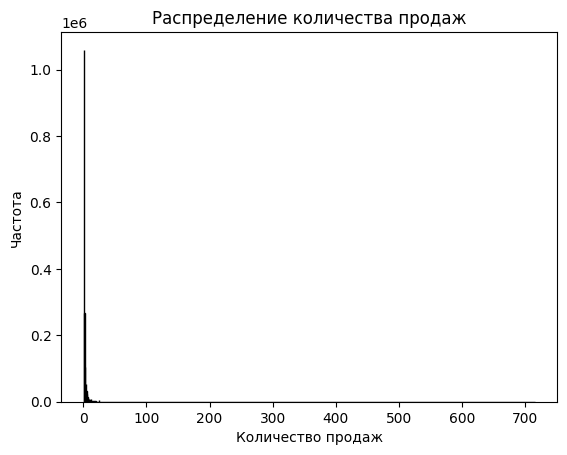

In [11]:
# matplotlib histogram
plt.hist(data['item_cnt'], color = 'blue', edgecolor = 'black',bins = int(1000))
# Add labels
plt.title('Распределение количества продаж')
plt.xlabel('Количество продаж')
plt.ylabel('Частота')

In [12]:
#skewness and kurtosis
print("Skewness: %f" % data['item_cnt'].skew())
print("Kurtosis: %f" % data['item_cnt'].kurt())

Skewness: 60.967598
Kurtosis: 9851.379669


# **Skewness:**

The skewness value is considerably greater than zero.
A positive skewness value indicates a right-skewed distribution of the data.
This suggests that there is a tail on the right side of the distribution, meaning that there are some unusually large values.

# **Kurtosis:**

The kurtosis value is significantly greater than zero.
A positive kurtosis value indicates a distribution with heavier tails and a sharper peak compared to a normal distribution.


In [ ]:
data.describe()

,date_block_num,shop_id,item_category_id,item_id,item_price_min,item_price_mean,item_cnt
count,1608202.00,1608202.00,1608202.00,1608202.00,1608202.00,1608202.00,1608202.00
mean,14.67,33.09,41.55,10681.49,782.50,789.95,2.01
std,9.54,16.47,16.32,6238.88,1511.88,1530.24,3.32
min,0.00,2.00,0.00,0.00,0.07,0.09,1.00
25%,6.00,21.00,30.00,5046.00,199.00,199.00,1.00
50%,14.00,31.00,40.00,10497.00,398.00,399.00,1.00
75%,23.00,48.00,55.00,16060.00,849.00,894.92,2.00
max,33.00,59.00,83.00,22169.00,50999.00,50999.00,713.97


# **Feature Engineering**

In [83]:
from sklearn.preprocessing import LabelEncoder
class FeatureEngineering:

    def __init__(self, start_block_num, end_block_num):
        self.start_block_num = start_block_num
        self.end_block_num  = end_block_num

    def feature_engineering(self, data):
        data1 = data.copy()

        data = data.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id','item_category_name',
        'shop_name'], as_index=False).agg({'item_cnt_day':['sum']})
        data.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id','item_category_name',
        'shop_name','item_cnt']

        # Clip the outlines
        # data['item_cnt'] = data.groupby('item_category_name')['item_cnt'].transform(lambda x: x.clip(x.quantile(0.01), x.quantile(0.99)))


        # Попробуем просто урезать данные до 20
        data['item_cnt'] = data['item_cnt'].clip(0, 20)

        df_pivot = data.pivot_table(
            index = ['shop_id', 'item_category_id', 'item_id','item_category_name',
        'shop_name'],
            columns = 'date_block_num',
            values = 'item_cnt',
            aggfunc='sum').fillna(0.0)
        df_pivot = df_pivot.reset_index()

        str_columns = [col for col in df_pivot.columns if isinstance(col, str)]
        int_columns = [col for col in df_pivot.columns if isinstance(col, int)]
        # Группируем по колонкам с типом str и агрегируем сумму по колонкам с типом int
        df_pivot = df_pivot.groupby(str_columns)[int_columns].sum().reset_index()
        # Select columns with a given range
        selected_cols = df_pivot.loc[:, self.start_block_num : self.end_block_num]
        # Create a new item average column
        selected_cols['mean_item_cnt'] = selected_cols.mean(axis=1)
        # return pd.DataFrame(selected_cols)
        data = pd.concat([df_pivot[['shop_id','item_id','item_category_name','shop_name', 'item_category_id']], selected_cols], axis=1)

        # # Получение таблицы динамики цены
        data1 = data1.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id','item_category_name',
        'shop_name'], as_index=False).agg({'item_price':['mean'], 'item_cnt_day':['sum']})
        data1.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id','item_category_name',
        'shop_name','item_price','item_cnt']

        df_pivot1 = data1.pivot_table(
            index = ['shop_id', 'item_category_id', 'item_id','item_category_name',
        'shop_name','item_cnt'],
            columns = 'date_block_num',
            values = 'item_price',
            aggfunc='mean').fillna(0.0)
        df_pivot1 = df_pivot1.reset_index()
        data1 = df_pivot1.groupby(str_columns)[int_columns].sum().reset_index()

        data1 = data1.loc[:, self.start_block_num : self.end_block_num]
        rename_dict = {col: f'Price {i+1}' for i, col in enumerate([col for col in data1.columns][::-1])}
        data1.rename(columns=rename_dict, inplace=True)

        data = pd.concat([data, data1], axis=1)

        # Generating features from the text string of the category name and store name
        data['item_category_name'] = data['item_category_name'].apply(lambda name: re.sub(r'[^\w\s]', '', str(name).split()[0]).strip())
        data['shop_name'] = data['shop_name'].apply(lambda name: re.sub(r'[^\w\s]', '', str(name).split()[0]).strip())

        label_encoder = LabelEncoder()
        data['shop_name'] = label_encoder.fit_transform(data['shop_name'])
        data['item_category_name']  = label_encoder.fit_transform(data['item_category_name'])

        # Let's find the average lag values ​​for various groups
        # List of columns with names in int format
        num_col_names = [col for col in data.columns if isinstance(col, int)]
        # Grouping by shop_id and item_id, calculating the average
        group_means_shop_item = data.groupby(['shop_id', 'item_id'])[num_col_names].mean().mean(axis=1).reset_index(name='shop_item_cnt_mean')
        # Grouping by shop_id and item_category_id, calculating the average
        group_means_shop_item_category = data.groupby(['shop_id', 'item_category_name'])[num_col_names].mean().mean(axis=1).reset_index(name='shop_item_category_id_cnt_mean')
        # Grouping by shop_name and item_id, calculating the average
        group_means_sity_item_id = data.groupby(['shop_name', 'item_id'])[num_col_names].mean().mean(axis=1).reset_index(name='sity_item_id_cnt_mean')

        # Grouping by shop_name and item_id, calculating the average NEW
        group_means_shop_item_categor = data.groupby(['shop_id', 'item_category_name'])[num_col_names].mean().mean(axis=1).reset_index(name='shop_item_category_cnt_mean')
        group_means_sity_category_id_cnt_mean = data.groupby(['shop_name', 'item_category_id'])[num_col_names].mean().mean(axis=1).reset_index(name='sity_category_id_cnt_mean')
        group_means_sity_item_category = data.groupby(['shop_name', 'item_category_name'])[num_col_names].mean().mean(axis=1).reset_index(name='sity_item_category')

        # Merging with the original dataframe to add new columns
        data = data.merge(group_means_shop_item, on=['shop_id', 'item_id'], how='left')
        data = data.merge(group_means_shop_item_category, on=['shop_id', 'item_category_name'], how='left')
        data = data.merge(group_means_sity_item_id, on=['shop_name', 'item_id'], how='left')
        # NEW
        data = data.merge(group_means_shop_item_categor, on=['shop_id', 'item_category_name'], how='left')
        data = data.merge(group_means_sity_category_id_cnt_mean, on=['shop_name', 'item_category_id'], how='left')
        data = data.merge(group_means_sity_item_category, on=['shop_name', 'item_category_name'], how='left')

        # Находим колонку с максимальным индексом
        y_col_name = max([col for col in data.columns if isinstance(col, int)])

        data['year'] = (y_col_name//12) + 2013
        data['season'] = y_col_name % 4
        data['month'] = y_col_name % 12

        return data

train_data = merged_data.copy()
# Создаем экземпляр класса DataProcessor
processor = FeatureEngineering(start_block_num=0,end_block_num=33)

train_data = processor.feature_engineering(train_data)
train_data

,shop_id,item_id,item_category_name,shop_name,item_category_id,0,1,2,3,4,...,Price 1,shop_item_cnt_mean,shop_item_category_id_cnt_mean,sity_item_id_cnt_mean,shop_item_category_cnt_mean,sity_category_id_cnt_mean,sity_item_category,year,season,month
0,2,5571,1,0,2,0.00,0.00,0.00,0.00,1.00,...,0.00,0.03,0.27,0.03,0.27,0.20,0.27,2015,1,9
1,2,5572,1,0,2,9.00,1.00,1.00,2.00,2.00,...,0.00,1.03,0.27,1.03,0.27,0.20,0.27,2015,1,9
2,2,5573,1,0,2,2.00,2.00,0.00,0.00,0.00,...,0.00,0.35,0.27,0.35,0.27,0.20,0.27,2015,1,9
3,2,5574,1,0,2,0.00,3.00,2.00,3.00,0.00,...,0.00,0.38,0.27,0.38,0.27,0.20,0.27,2015,1,9
4,2,5575,1,0,2,4.00,5.00,1.00,3.00,0.00,...,0.00,0.50,0.27,0.50,0.27,0.20,0.27,2015,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424084,59,9254,12,30,80,0.00,0.00,0.00,0.00,0.00,...,0.00,0.24,2.26,0.24,2.26,0.29,2.26,2015,1,9
424085,59,22087,14,30,83,9.00,1.00,6.00,0.00,2.00,...,119.00,6.24,3.92,6.24,3.92,3.92,3.92,2015,1,9
424086,59,22088,14,30,83,5.00,0.00,5.00,3.00,6.00,...,119.00,5.79,3.92,5.79,3.92,3.92,3.92,2015,1,9
424087,59,22091,14,30,83,0.00,0.00,1.00,0.00,2.00,...,179.00,1.15,3.92,1.15,3.92,3.92,3.92,2015,1,9


# **Для целей исследования сформируем выборку из первых 12 месяцев и посмотрим корреляцию между целевым признаком (последним месяцем) и всем признаковым пространством**

In [67]:
processor = FeatureEngineering(start_block_num=0,end_block_num=12)
train_data12 = processor.feature_engineering(merged_data)
train_data12

,shop_id,item_id,item_category_name,shop_name,item_category_id,0,1,2,3,4,...,Price 1,shop_item_cnt_mean,shop_item_category_id_cnt_mean,sity_item_id_cnt_mean,shop_item_category_cnt_mean,sity_category_id_cnt_mean,sity_item_category,year,season,month
0,2,5571,1,0,2,0.00,0.00,0.00,0.00,1.00,...,0.00,0.08,0.30,0.08,0.30,0.33,0.30,2014,0,0
1,2,5572,1,0,2,9.00,1.00,1.00,2.00,2.00,...,1589.85,1.85,0.30,1.85,0.30,0.33,0.30,2014,0,0
2,2,5573,1,0,2,2.00,2.00,0.00,0.00,0.00,...,0.00,0.54,0.30,0.54,0.30,0.33,0.30,2014,0,0
3,2,5574,1,0,2,0.00,3.00,2.00,3.00,0.00,...,0.00,1.00,0.30,1.00,0.30,0.33,0.30,2014,0,0
4,2,5575,1,0,2,4.00,5.00,1.00,3.00,0.00,...,0.00,1.31,0.30,1.31,0.30,0.33,0.30,2014,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424084,59,9254,12,30,80,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.15,0.00,0.15,0.00,0.15,2014,0,0
424085,59,22087,14,30,83,9.00,1.00,6.00,0.00,2.00,...,79.00,8.62,4.69,8.62,4.69,4.69,4.69,2014,0,0
424086,59,22088,14,30,83,5.00,0.00,5.00,3.00,6.00,...,79.00,5.46,4.69,5.46,4.69,4.69,4.69,2014,0,0
424087,59,22091,14,30,83,0.00,0.00,1.00,0.00,2.00,...,109.00,1.15,4.69,1.15,4.69,4.69,4.69,2014,0,0


# **Relationship with numerical variables**

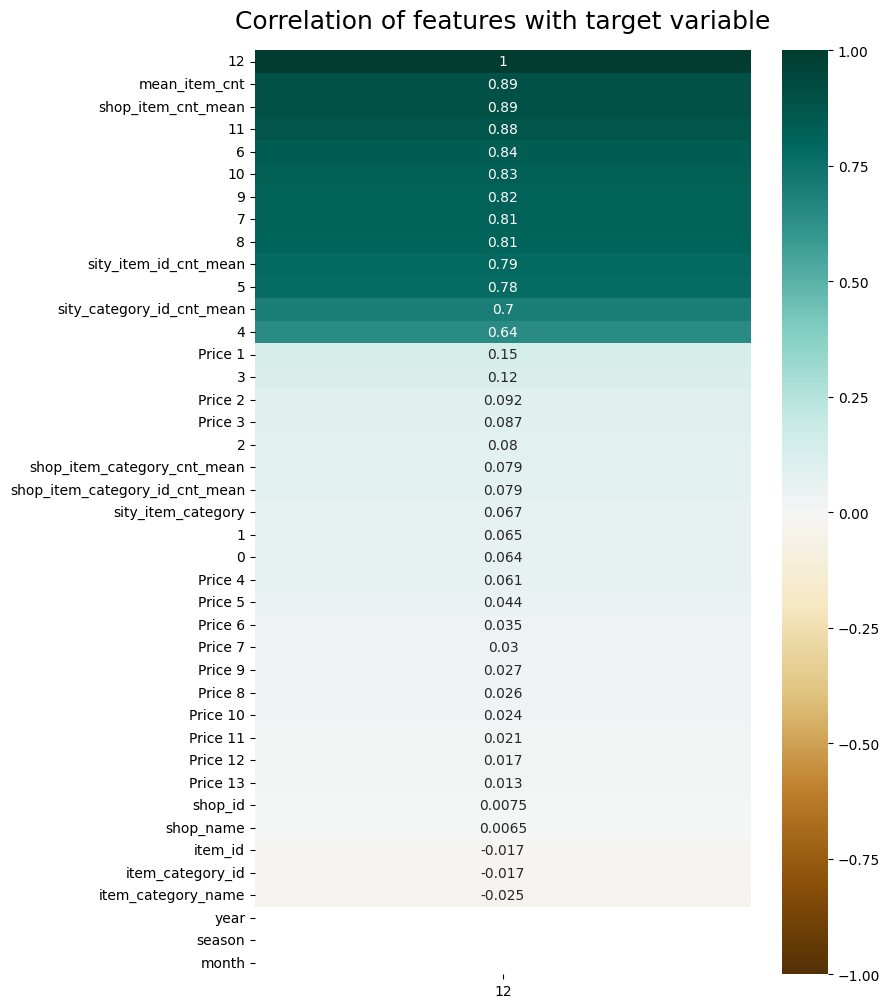

In [71]:
#Correlation of features with mean target variable
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(train_data12.corr()[[12]].sort_values(by=12, ascending=False)
, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation of features with target variable', fontdict={'fontsize':18}, pad=16);

In [84]:
# Выберите столбцы 1, 2 и 3 и выполните сравнение с 20
are_columns_equal = train_data['mean_item_cnt'].equals(train_data['shop_item_cnt_mean'])
are_columns_equal

False

# **Будем двигаться окном и создавать тренировочные, валидационную и тестовую выборки окном в 6 месяцев и генерировать фичи только по этому окну, чтобы избежать утечки данных**

In [86]:
processor = FeatureEngineering(start_block_num=0,end_block_num=6)
train_data1 = processor.feature_engineering(merged_data)

In [87]:
processor = FeatureEngineering(start_block_num=6,end_block_num=12)
train_data2= processor.feature_engineering(merged_data)

In [88]:
processor = FeatureEngineering(start_block_num=13,end_block_num=19)
train_data3= processor.feature_engineering(merged_data)

In [89]:
processor = FeatureEngineering(start_block_num=20,end_block_num=26)
val_data = processor.feature_engineering(merged_data)

In [90]:
processor = FeatureEngineering(start_block_num=27,end_block_num=33)
test_data = processor.feature_engineering(merged_data)

# *Let's write a get_data() function that will divide the resulting dataset into x and y sets, in accordance with the fact that the y column should be of the largest index (the last month number in the list). The function will also rename columns with lags.*

In [91]:
def get_data(data):
    # Находим колонку с максимальным индексом
    y_col_name = max([col for col in data.columns if isinstance(col, int)])
    X_train = data.drop([y_col_name], axis=1)
    y_train = data[y_col_name]
    # Переименуем лаги в x_train
    rename_dict = {col: f'lag {i+1}' for i, col in enumerate([col for col in X_train .columns if isinstance(col, int)][::-1])}
    X_train.rename(columns=rename_dict, inplace=True)
    y_train.columns = ['y']
    return X_train, y_train

# **We will generate data for training, validating and testing the model**

In [92]:
X_train1, y_train1 = get_data(train_data1)
print(X_train1.shape)
X_train2, y_train2 = get_data(train_data2)
print(X_train2.shape)
X_train3, y_train3 = get_data(train_data3)
print(X_train3.shape)
X_val, y_val = get_data(val_data)
print(X_val.shape)
X_test, y_test = get_data(test_data)
print(X_test.shape)

(424089, 28)
(424089, 28)
(424089, 28)
(424089, 28)
(424089, 28)


# **Объединим тренировочные данные**

In [93]:
X_train = pd.concat([X_train1, X_train2, X_train3], ignore_index=True)
y_train = pd.concat([y_train1, y_train2,y_train3,], ignore_index=True)
print(X_train.shape)
print(y_train.shape)

(1272267, 28)
(1272267,)


# **Подбор гиперпараметров модели на валидационном датасете**

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# Определим сетку параметров для подбора
xgb_pars = {
    'eta': [ 0.1, 0.3],
    'max_depth': [3, 6, 9],
    'subsample': [0.9],
    'colsample_bytree': [0.5, 0.7, 0.9],
    'objective': ['reg:squarederror']
}

# Преобразуем данные в формат xgb.DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Используем GridSearchCV для выбора лучших гиперпараметров
xgb_model = xgb.XGBRegressor()
grid = GridSearchCV(estimator=xgb_model, param_grid=xgb_pars, scoring='neg_mean_squared_error', cv=5)
grid.fit(X_train, y_train)

# Получим лучшие гиперпараметры
best_params = grid.best_params_
print("Best Parameters:", best_params)

# Оценка модели с лучшими гиперпараметрами на тестовом наборе данных
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

# Оценка качества модели на тестовом наборе данных
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on Test Set:", mse)

# Best Parameters: {'colsample_bytree': 0.7, 'eta': 0.3, 'max_depth': 3, 'objective': 'reg:squarederror', 'subsample': 0.9}

# **Обучение модели с наилучшими параметрами, подобранными на валидационном датасете**

In [99]:
feature_names = list(X_train.columns)
# Создание объектов DMatrix для обучающего и валидационного наборов данных
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, feature_names=feature_names)

# Параметры модели
params = {
    'max_depth': 3,
    'colsample_bytree': 0.7,
    'objective': 'reg:squarederror',
    'subsample': 0.9,
    'eta': 0.3,
    'seed': 0
}
# Обучение модели с использованием xgb.train()
bst = xgb.train(params, dtrain, num_boost_round=100, evals=[(dtrain, 'train'), (dval, 'eval')], early_stopping_rounds=1, verbose_eval=20)


[0]	train-rmse:0.87327	eval-rmse:0.72279
[20]	train-rmse:0.50443	eval-rmse:0.47142
[27]	train-rmse:0.48492	eval-rmse:0.46069


In [100]:
# Предскажем значения для валидационной и тестовой выборок
from sklearn.metrics import mean_squared_error
y_val_pred = bst.predict(dval)
y_test_pred = bst.predict(dtest)

# # Оценим качество модели на валидационной и тестовой выборках
val_rmse = mean_squared_error(y_val, y_val_pred, squared=False)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

print("RMSE на валидационной выборке:", val_rmse)
print("RMSE на тестовой выборке:", test_rmse)

RMSE на валидационной выборке: 0.46068724465238253
RMSE на тестовой выборке: 0.4765895793697878


Доучим модель валидационным датасетом и проверим на тестовом

In [101]:
dval = xgb.DMatrix(X_val, label=y_val)
# Доучивание модели с использованием новых данных
bst1 = xgb.train(params, dval, num_boost_round=100, xgb_model=bst)
y_test_pred = bst1.predict(dtest)
# # Оценим качество модели на валидационной и тестовой выборках
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
print("RMSE на тестовой выборке:", test_rmse)

RMSE на тестовой выборке: 0.3032992198573149
